In [1]:
import torch
import os
import sys
import gc
import argparse
import torch.optim as optim
import numpy as np
import torch.nn as nn
import torch.backends.cudnn as cudnn
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms as T
from torch.utils.data import Dataset
from PIL import Image 
from torchvision.models.segmentation import deeplabv3_resnet50
import segmentation_models_pytorch as smp 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device, "\n")

/Users/hupan/Applications/anaconda3/envs/floodnet/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu 



In [2]:
class FloodNetDataset_Labeled(Dataset):
    """
        classes:
        
        "background",
        "building-flooded",
        "building non-flooded",
        "road flooded",
        "road non-flooded",
        "water",
        "tree",
        "vehicle",
        "pool",
        "grass",
            
    """

    def __init__(
        self, base_folder="./data/train", transform=lambda x: x,  target_transform=lambda y: y
    ) -> None:
        super().__init__()
        self.base_folder = base_folder
        self.im_files = [f for f in os.listdir(self.base_folder) if f.endswith(".jpg")]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.im_files)

    def __getitem__(self, index):
        img_file = os.path.join(self.base_folder, self.im_files[index])
        gt_file = img_file.replace(".jpg", "_lab.png")
        img = Image.open(img_file)
        label = Image.open(gt_file)
        state = torch.get_rng_state()
        img = self.transform(img)
        torch.set_rng_state(state)
        label = self.target_transform(label)

        return img, label

In [3]:
def dice_coef(y_pred, y_true, epsilon=1e-7):
    dice = []
    
    # compute for each class 
    classes = int(np.max(np.unique(y_true.detach().cpu().numpy())))
    for num_class in range(1, classes):
        target = (y_true == num_class)
        pred = (y_pred == num_class)
        
        intersect = (target * pred).sum()
        base = (target).sum() + (pred).sum()
        del(target); del(pred)
        
        score = (2 * intersect + epsilon) / (base + epsilon)
        dice.append(score)
        del(intersect); del(base)
    
    return (sum(dice) / len(dice)).item()

In [4]:
# UNET

class conv_block(nn.Module):

    def __init__(self, ch_in, ch_out, norm_layer=None):
        super(conv_block, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            #nn.BatchNorm2d(ch_out),
            norm_layer(num_features=ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            #nn.BatchNorm2d(ch_out),
            norm_layer(num_features=ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class up_conv(nn.Module):
    def __init__(self, ch_in, ch_out, norm_layer=None):
        super(up_conv, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            norm_layer(num_features=ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


class U_Net(nn.Module):
    def __init__(self, img_ch=3, output_ch=1, norm_layer=None):
        super(U_Net, self).__init__()

        self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(ch_in=img_ch, ch_out=64, norm_layer=norm_layer)
        self.Conv2 = conv_block(ch_in=64, ch_out=128, norm_layer=norm_layer)
        self.Conv3 = conv_block(ch_in=128, ch_out=256, norm_layer=norm_layer)
        self.Conv4 = conv_block(ch_in=256, ch_out=512, norm_layer=norm_layer)
        self.Conv5 = conv_block(ch_in=512, ch_out=1024, norm_layer=norm_layer)

        self.Up5 = up_conv(ch_in=1024, ch_out=512, norm_layer=norm_layer)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512, norm_layer=norm_layer)

        self.Up4 = up_conv(ch_in=512, ch_out=256, norm_layer=norm_layer)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256, norm_layer=norm_layer)

        self.Up3 = up_conv(ch_in=256, ch_out=128, norm_layer=norm_layer)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128, norm_layer=norm_layer)

        self.Up2 = up_conv(ch_in=128, ch_out=64, norm_layer=norm_layer)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64, norm_layer=norm_layer)

        self.Conv_1x1 = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # encoding path
        x1 = self.Conv1(x)
        # print("U_Net forward:", type(x))
        # print("U_Net forward:", x.shape)
        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)

        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)  # self.Conv4 = conv_block(ch_in=256,ch_out=512)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)  # self.Conv5 = conv_block(ch_in=512,ch_out=1024)
        # print("U_Net forward:", "encoding", type(x5))
        # print("U_Net forward:", "encoding", x5.shape)

        # decoding + concat path
        d5 = self.Up5(x5)  # self.Up5 = up_conv(ch_in=1024,ch_out=512)
        d5 = torch.cat((x4, d5), dim=1)

        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        # print("U_Net forward:", "dencoding", type(d1))
        # print("U_Net forward:", "dencoding shape", d1.shape)
        return d1

In [5]:
# define parmeters and folders
class Opt():
    def __init__(self):
        self.learning_rate = 0.001
        self.mean = [-0.2417,  0.8531,  0.1789]
        self.std = [0.9023, 1.1647, 1.3271] 
        self.print_freq = 20
        self.name_net = 'unet'  # pspnet, deeplab
        self.batch_size = 4
        self.num_workers = 2
        self.epochs = 15
        self.supervised_epochs = 10
        self.num_classes = 10
        self.resize_height = 256
        self.resize_width = 256
        self.b_factor = 1
        self.alpha = 1
        self.load_saved_model = False
        self.threshold_val_dice = 0.3

        # Folders
        self.path_to_pretrained_model = ''
        self.project_folder = './'
        self.labeled_data_folder = '/Users/hupan/Codes/Research/floodnet-segmentation/data'
        # self.unlabeled_data_folder = '/kaggle/input/floodnet-unlabeled/unsup segmentation kaggle/Train'
        self.results_folder = os.path.join(self.project_folder, 'model_unet')
        if not os.path.isdir(self.results_folder):
            os.makedirs(self.results_folder)
opt = Opt()

In [6]:
def set_model(opt):
    if opt.name_net == 'unet':
        model = U_Net(output_ch = opt.num_classes)
        
    if opt.name_net == 'pspnet':
        model = smp.PSPNet('resnet34', in_channels=3, classes = opt.num_classes)

    if opt.name_net == 'deeplab':
        model = deeplabv3_resnet50(num_classes = opt.num_classes)
   
    criterion = nn.CrossEntropyLoss()
    criterion_psl = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=opt.learning_rate)
    
    if opt.load_saved_model:
        path = os.path.join(opt.path_to_pretrained_model, opt.name_net +'_best.pth')
        checkpoint = (torch.load(path,map_location=torch.device('cpu')))
        model.load_state_dict(checkpoint['model']) 
        
        
    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
        cudnn.benchmark = True

    return model, criterion, criterion_psl, optimizer

In [7]:
def save_model(model, optimizer, opt, epoch, save_file):
    print('==> Saving...')
    state = {
        'opt': opt,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch,
    }
    torch.save(state, save_file)
    del state

In [8]:
def set_loader(opt):
    
    train_transform = T.Compose([
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.Resize((opt.resize_height, opt.resize_width)),
        T.ToTensor(),
        T.Normalize(mean=opt.mean, std=opt.std)
    ])
    
    val_transform = T.Compose([
        T.Resize((opt.resize_height, opt.resize_width)),
        T.ToTensor(),
        T.Normalize(mean=opt.mean, std=opt.std)
    ])
    train_target_transform = T.Compose([
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.Resize((opt.resize_height, opt.resize_width)),
        T.PILToTensor(),
        ])
        
    val_target_transform = T.Compose([
        T.Resize((opt.resize_height, opt.resize_width)),
        T.PILToTensor(),
        ])


    train_dir = opt.labeled_data_folder + '/train'
    val_dir = opt.labeled_data_folder + '/val'
    # unsup_train_dir = opt.unlabeled_data_folder +'/image'
    train_dataset = FloodNetDataset_Labeled(train_dir, transform=train_transform , target_transform=train_target_transform)
    validation_dataset = FloodNetDataset_Labeled(val_dir, transform=val_transform , target_transform=val_target_transform)
    # unsup_train_dataset = FloodNetDataset_Unlabeled(unsup_train_dir, transform=train_transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=opt.batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=opt.batch_size, shuffle=True)
    # unsup_train_loader =  torch.utils.data.DataLoader(unsup_train_dataset, batch_size=opt.b_factor * opt.batch_size, shuffle=True)

    # return train_loader, test_loader, unsup_train_loader
    return train_loader, val_loader

In [9]:
def test(model, test_loader, criterion, opt):
    model.eval()
    val_loss = 0
    val_dice = 0
    total_num = 0
    with torch.no_grad():
        for image, mask in test_loader:
            if torch.cuda.is_available():
                image = image.cuda(non_blocking=True)
                mask = mask.cuda(non_blocking=True)
                
            if opt.name_net == 'deeplab':
                output = model(image)['out'] # with deeplab from torch
            else:
                output = model(image)
                
            mask = torch.squeeze(mask, dim = 1)
            loss = criterion(output, mask.long()) # mask.long() if using cross entropy
            total_num += mask.shape[0]
            val_loss += loss.item() * mask.shape[0]
            dice = dice_coef(output.argmax(dim=1), mask)
            val_dice += dice
    
    val_loss = val_loss / total_num      
    val_dice = val_dice / len(test_loader)
    print("validation loss", val_loss)
    print("validation DICE coefficient", val_dice) 
    
    return val_loss, val_dice

In [10]:
def train(model, train_loader, val_loader, criterion, criterion_psl, optimizer, epoch, opt):
    model.train()
    total_loss, total_num = 0.0, 0
    idx = 0
    
    if epoch< opt.supervised_epochs:
        # for image, mask in train_loader:
        for image, mask in train_loader:
            optimizer.zero_grad()
            # print(torch.unique(mask)) # Must be integers
            if torch.cuda.is_available():
                image = image.cuda(non_blocking=True)
                mask = mask.cuda(non_blocking=True)
            # forward + backward + optimize
            if opt.name_net == 'deeplab':
                output = model(image)['out'] # with deeplab from torch
            else:
                output = model(image)
                
            mask = torch.squeeze(mask, dim = 1)
            # print('mask shape', mask.shape)
            # print('output shape', output.shape)
            loss = (1/image.shape[0]) * criterion(output, mask.long()) # mask.long() if using cross entropy
            loss.backward()
            optimizer.step()
            total_num += mask.shape[0]
            total_loss += loss.item() * mask.shape[0]
        
        if (idx + 1) % opt.print_freq == 0:
            print('Fully_supervised-Train Epoch: [{}/{}], lr: {:.6f}, Loss: {}'.format(epoch, opt.epochs,
                                                                    optimizer.param_groups[0]['lr'],
                                                                    total_loss / total_num))
            sys.stdout.flush()
        idx += 1

    

    gc.collect()
    torch.cuda.empty_cache()
    val_loss, val_dice = test(model, val_loader, criterion, opt)
    print("train() function - epoch total_loss", total_loss / total_num)
    train_loss = total_loss / total_num
    return train_loss, val_loss, val_dice 

In [11]:
torch.cuda.empty_cache()

# build data loader
train_loader, val_loader = set_loader(opt)
print('train e test data loader created...')

# define model
model, criterion, criterion_psl, optimizer = set_model(opt)
save_file_1 = os.path.join(opt.results_folder, (str(opt.name_net) + '_best.pth'))

# TRAINING
print("Training...")

# training routine
best_val_dice = opt.threshold_val_dice
train_loss_values, val_loss_values, val_dices = [], [], []

for epoch in range(1, opt.epochs + 1):

    train_loss, val_loss, val_dice = train(model, train_loader, val_loader, criterion, criterion_psl, optimizer, epoch, opt)
    train_loss_values.append(train_loss)
    val_loss_values.append(val_loss)
    val_dices.append(val_dice)

    # save best model
    if val_dice > best_val_dice:
        print("saving/updating current best model at epoch=" + str(epoch))
        save_model(model, optimizer, opt, epoch, save_file_1)
        best_val_dice = val_dice

    save_file_2 = os.path.join(opt.results_folder, (str(opt.name_net) + '_last.pth'))
    save_model(model, optimizer, opt, opt.epochs, save_file_2)

    # save loss values and plot
    tloss_df = pd.DataFrame(train_loss_values)
    vloss_df = pd.DataFrame(val_loss_values)
    dice_df = pd.DataFrame(val_dices)
    tloss_df.to_csv(opt.results_folder +'/' + (str(opt.name_net) + '_train_loss.csv'))
    vloss_df.to_csv(opt.results_folder +'/' + (str(opt.name_net) + '_val_loss.csv'))
    dice_df.to_csv(opt.results_folder +'/' + (str(opt.name_net) + '_val_dice.csv'))

    plt.figure(figsize=(15, 10))
    plt.plot(train_loss_values, label = 'train loss')
    plt.ylabel('train loss value')
    plt.xlabel('epochs')
    plt.savefig(opt.results_folder +'/' + str(opt.name_net) + ' _train_loss.png')
    plt.close()

    plt.figure(figsize=(15, 10))
    plt.plot(val_loss_values, label = 'validation loss')
    plt.ylabel('validation loss value')
    plt.xlabel('epochs')
    plt.savefig(opt.results_folder +'/' + str(opt.name_net) + ' _val_loss.png')
    plt.close()

    plt.figure(figsize=(15, 10))
    plt.plot(val_dices)
    plt.ylabel('dice value')
    plt.xlabel('epochs')
    plt.savefig(opt.results_folder +'/' + str(opt.name_net) + ' _val_dice.png')
    plt.close()


train e test data loader created...
Training...


KeyboardInterrupt: 

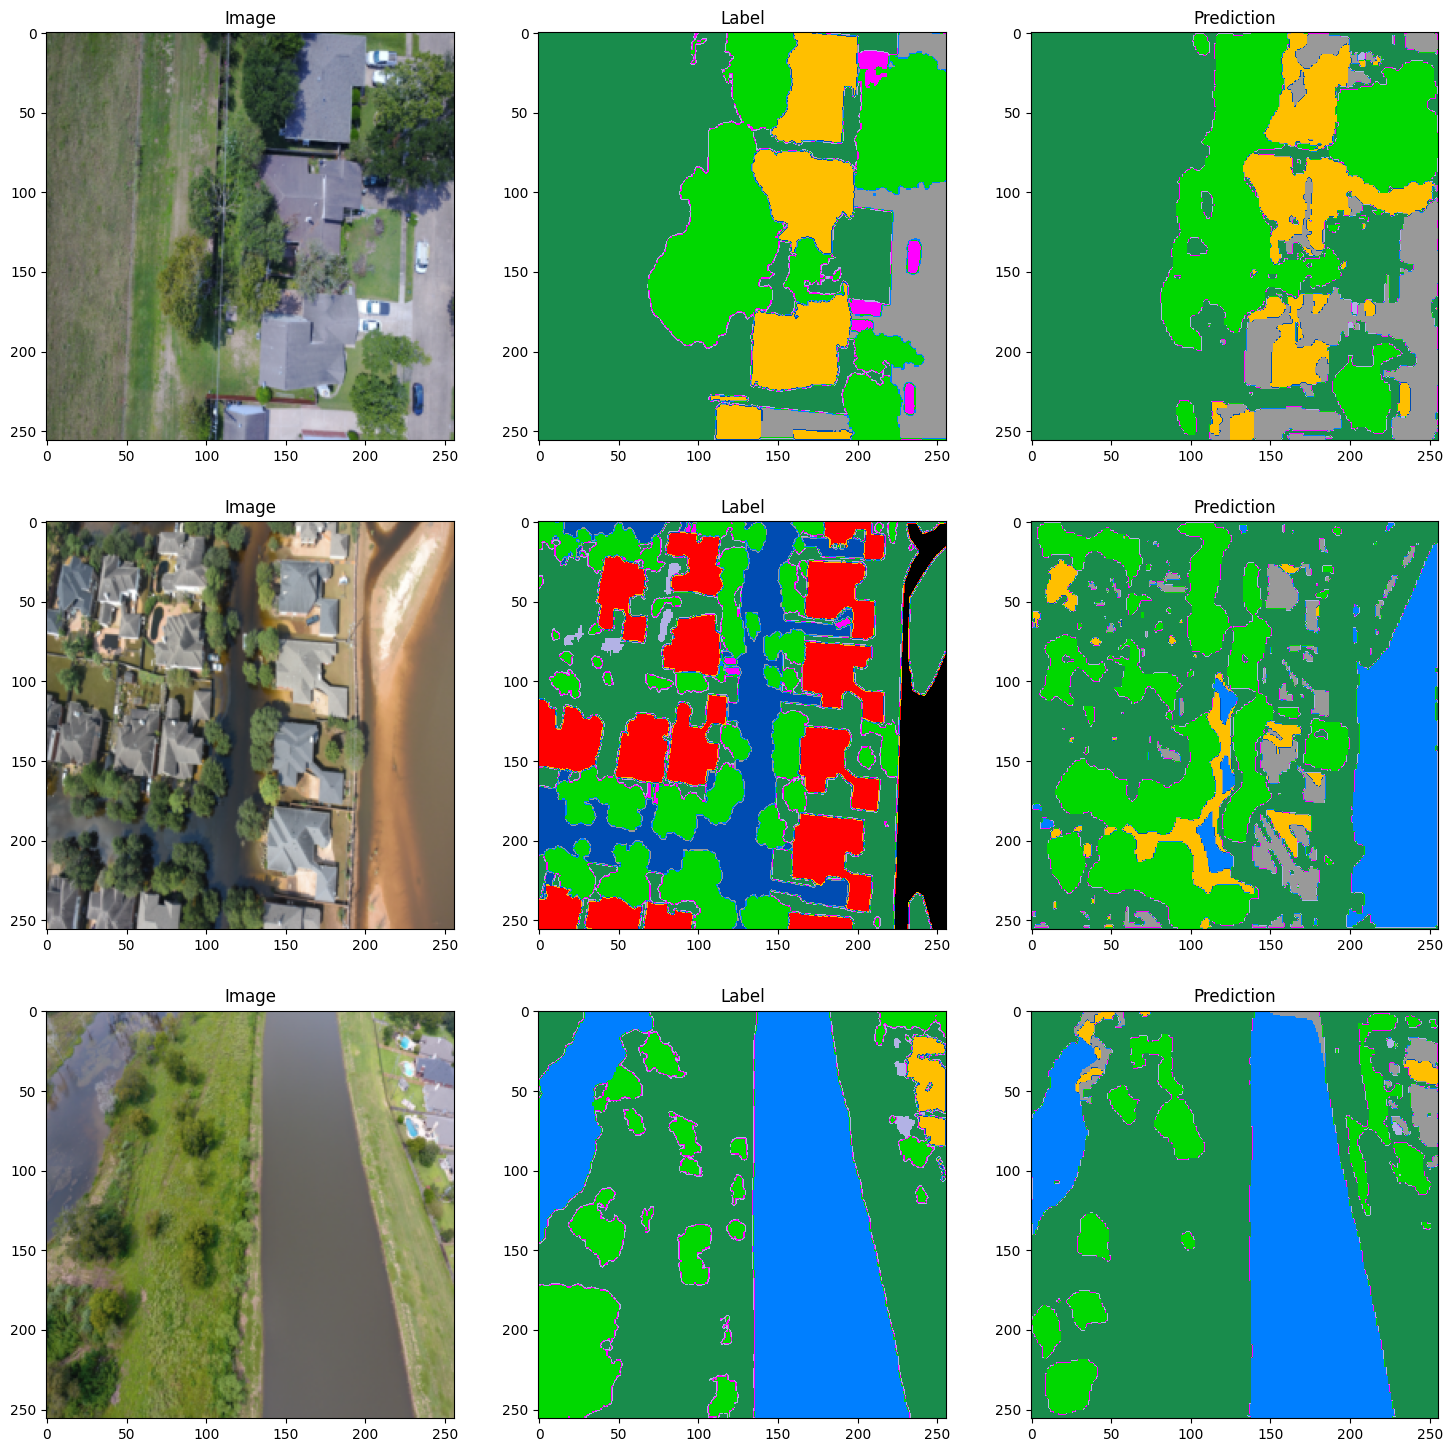

In [14]:
# Plot results

from matplotlib.colors import ListedColormap

custom_colors = [[0, 0, 0], 
                [1, 0, 0],  
                [1, 0.75, 0],   
                [0, 0.3, 0.7], 
                [0.6, 0.6, 0.6],   
                [0, 0.5, 1],   
                [0, 0.85, 0],   
                [1, 0, 1], 
                [0.7, 0.7, 0.9], 
                [0.1, 0.55, 0.3]]

color_names = ['background', 'building-flooded', 'building non-flooded', 'road flooded', 'road non-flooded', 'water', 'tree', 'vehicle', 'pool', 'grass']
custom_cmap = ListedColormap(custom_colors)

def unnormalize(tensor, mean = [-0.2417,  0.8531,  0.1789], std = [0.9023, 1.1647, 1.3271]):
    """
    Unnormalizes a tensor given mean and standard deviation.
    
    Args:
        tensor (torch.Tensor): Input tensor to be unnormalized.
        mean (float or sequence): Mean value(s) for unnormalization.
        std (float or sequence): Standard deviation value(s) for unnormalization.
        
    Returns:
        torch.Tensor: Unnormalized tensor.
    """
    if not torch.is_tensor(tensor):
        raise TypeError("Input tensor should be a torch.Tensor")
    
    mean = torch.tensor(mean, device=tensor.device, dtype=tensor.dtype)
    std = torch.tensor(std, device=tensor.device, dtype=tensor.dtype)
    
    unnormalized_tensor = tensor * std + mean
    return unnormalized_tensor

model.eval()

val_transform = T.Compose([
    T.Resize((opt.resize_height, opt.resize_width)),
    T.ToTensor(),
    T.Normalize(mean=opt.mean, std=opt.std)
])
val_target_transform = T.Compose([
    T.Resize((opt.resize_height, opt.resize_width)),
    T.PILToTensor(),
])

im1 = Image.open('./data/val/6651.jpg')
im2 = Image.open('./data/val/7488.jpg')
im3 = Image.open('./data/val/6734.jpg')

mask1 = Image.open('./data/val/6651_lab.png')
mask2 = Image.open('./data/val/7488_lab.png')
mask3 = Image.open('./data/val/6734_lab.png')

im1 = val_transform(im1)
im2 = val_transform(im2)
im3 = val_transform(im3)

mask1 = val_target_transform(mask1)
mask2 = val_target_transform(mask2)
mask3 = val_target_transform(mask3)

if torch.cuda.is_available():
    im1 = im1.cuda(non_blocking=True)
    #mask1 = mask1.cuda(non_blocking=True)
    im2 = im2.cuda(non_blocking=True)
    #mask2 = mask2.cuda(non_blocking=True)
    im3 = im3.cuda(non_blocking=True)
    #mask3 = mask3.cuda(non_blocking=True)
    
if opt.name_net == 'deeplab': 
    pred1 = model(im1[None,:,:,:])['out']
    pred2 = model(im2[None,:,:,:])['out']
    pred3 = model(im3[None,:,:,:])['out']
else:
    pred1 = model(im1[None,:,:,:])
    pred2 = model(im2[None,:,:,:])
    pred3 = model(im3[None,:,:,:])
    
pred1 = torch.squeeze(pred1)
pred1 = pred1.argmax(0).squeeze()
pred1 = pred1.cpu().detach().numpy()
pred2 = torch.squeeze(pred2)
pred2 = pred2.argmax(0).squeeze()
pred2 = pred2.cpu().detach().numpy()
pred3 = torch.squeeze(pred3)
pred3 = pred3.argmax(0).squeeze()
pred3 = pred3.cpu().detach().numpy()

fig, ax =  plt.subplots(3, 3, figsize=(18, 18))
ax[0][0].set_title('Image')
ax[0][1].set_title('Label')
ax[0][2].set_title('Prediction')
ax[1][0].set_title('Image')
ax[1][1].set_title('Label')
ax[1][2].set_title('Prediction')
ax[2][0].set_title('Image')
ax[2][1].set_title('Label')
ax[2][2].set_title('Prediction')
ax[0][0].imshow(np.squeeze(unnormalize(np.transpose(im1.squeeze().cpu(),(1,2,0)))))
ax[0][1].imshow(mask1.squeeze(), cmap = custom_cmap, vmin = 0, vmax = 9)
ax[0][2].imshow(pred1.squeeze(), cmap = custom_cmap, vmin = 0, vmax = 9)
ax[1][0].imshow(np.squeeze(unnormalize(np.transpose(im2.squeeze().cpu(),(1,2,0)))))
ax[1][1].imshow(mask2.squeeze(), cmap = custom_cmap, vmin = 0, vmax = 9)
ax[1][2].imshow(pred2.squeeze(), cmap = custom_cmap, vmin = 0, vmax = 9)
ax[2][0].imshow(np.squeeze(unnormalize(np.transpose(im3.squeeze().cpu(),(1,2,0)))))
ax[2][1].imshow(mask3.squeeze(), cmap = custom_cmap, vmin = 0, vmax = 9)
ax[2][2].imshow(pred3.squeeze(), cmap = custom_cmap, vmin = 0, vmax = 9)


